In [9]:
%load_ext autoreload
%autoreload 2
import static_model
import read_data
import numpy as np
import seaborn as sns
import networkx as nx
import graphviz as gv
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# for sioux falls, read all the files
net_file_name = '../TransportationNetworks/SiouxFalls/SiouxFalls_net.tntp'
num_nodes, num_arcs, arc_set, free_flow_time, capacity = read_data.report_net_data_tntp(net_file_name)
origin_node = [6 - 1, 10 - 1, 23 - 1]
dest_node = [1 - 1, 13 - 1, 18 - 1, 20 - 1]
trip_file_name = '../TransportationNetworks/SiouxFalls/SiouxFalls_trips.tntp'
demand = read_data.read_flow_data_trip_tntp(trip_file_name, origin_node)
bpr_params = [0.15, 4]
# solve the static model
shortest_path_per_node, _ = read_data.find_shortest_path(free_flow_time, origin_node, dest_node)
# convert shortest path to arc set
shortest_path = {}
for i in origin_node:
    path = shortest_path_per_node[i]
    for j in range(len(path) - 1):
        cur_link = (path[j], path[j + 1])
        if cur_link not in shortest_path.keys():
            shortest_path[cur_link] = [i]
        else:
            shortest_path[cur_link].append(i)

In [6]:
trust = {}
for i in origin_node:
    trust[i] = 0.32
m, x, z, obj, x_val, z_val = static_model.solve_static_model(arc_set, origin_node, dest_node, num_nodes, bpr_params,
                                                                 trust, demand, capacity, free_flow_time, shortest_path)

In [7]:
print('Final objective', obj / sum(demand.values()) * 0.6)
print('Flow on each arc:')
for arc in arc_set:
    if x_val[arc] > 1e-3:
        print(arc, x_val[arc], z_val[arc])

Final objective 271.37243552606003
Flow on each arc:
(1, 0) 0.4555284107551896 0.4555284107551896
(2, 0) 0.4093733259904892 0.4093733259904892
(3, 2) 0.40938255290348435 0.40938255290348435
(4, 3) 0.40937541927484433 0.40937541927484433
(5, 1) 0.45553689299484745 0.45553689299484745
(5, 7) 0.22002011888096296 1.6555756744365182
(6, 17) 0.22005822781588247 1.6556137833714377
(7, 6) 0.22006085577094847 1.6556164113265037
(8, 4) 0.4093798613204617 0.4093798613204617
(9, 8) 0.40943214112135906 0.40943214112135906
(9, 10) 1.3082771135737274 1.3082771135737274
(9, 14) 2.2995981223498743 2.2995981223498743
(10, 11) 1.308246357812778 1.308246357812778
(11, 12) 1.3082441729277807 1.3082441729277807
(14, 18) 1.521871295755641 1.521871295755641
(14, 21) 0.7777220893549929 0.7777220893549929
(18, 19) 1.5223119697103378 1.5223119697103378
(20, 19) 0.6959045308244897 0.6959045308244897
(21, 19) 1.3706750334789255 1.3706750334789255
(21, 20) 0.6959231159942637 0.6959231159942637
(22, 21) 1.2888836778

In [18]:
# consider the information gain of each arc
zero_num_reports = {}
for arc in arc_set:
    zero_num_reports[arc] = 0
m, x, z, obj, x_val, z_val = static_model.solve_static_model(arc_set, origin_node, dest_node, num_nodes, bpr_params,
                                                                 trust, demand, capacity, free_flow_time, shortest_path,
                                                             explore=zero_num_reports, report_threshold=0.1, eta=1.5)
print('Final objective', obj / sum(demand.values()) * 0.6)
variance_flow = 0
weight = {}
for i, j in arc_set:
    weight[i, j] = 1 / (zero_num_reports[i, j] + 1e-3)
    variance_flow += (z_val[i, j] - weight[i, j] / sum(weight.values()) * sum(demand.values())) * (
            z_val[i, j] - weight[i, j] / sum(weight.values()) * sum(demand.values()))
variance_flow = 1 * variance_flow
print('flow variance:', variance_flow)
print('Flow on each arc:')
for arc in arc_set:
    if x_val[arc] > 1e-3:
        print(arc, x_val[arc], z_val[arc])
print(m.objval, obj)

Add information gain objective
Final objective 277.51982561685435
flow variance: 324.7751035693184
Flow on each arc:
(0, 1) 8.377021128233121 8.377021128233121
(0, 2) 4.7565676068748335 4.7565676068748335
(1, 0) 7.760786063314514 7.760786063314514
(1, 5) 1.227421685400813 1.2274216853927173
(2, 0) 5.020570435404928 5.020570435404928
(2, 3) 0.5311785662935953 0.5311785662935953
(2, 11) 1.4127920896648645 1.4127920896648645
(3, 2) 2.2079832391938234 2.2079832391938234
(3, 4) 0.41554935781172875 0.41554935781172875
(4, 3) 2.0139468387670725 2.0139468387670725
(5, 1) 0.6111966150228175 0.6111966150228175
(5, 4) 0.9844154911542028 0.9844154911542028
(5, 7) 0.30736540451747607 1.7429209600730313
(6, 17) 0.47574435294404616 1.9112999084996014
(7, 6) 0.4757542900954994 1.9113098456510547
(8, 4) 0.6139922744410227 0.6139922744410227
(8, 7) 0.16839883565746702 0.16839883565746702
(9, 8) 0.7824011141784207 0.7824011141784207
(9, 10) 1.0547878030397497 1.0547878030397497
(9, 14) 1.429297855078316 

In [ ]:
# test if there are random arcs in the arc set is destroyed

In [8]:
# define trust parameters and test the model
# define trust list from 0.1 to 1
trust_list = np.arange(0.1, 1.1, 0.1)
# test each trust in trust_list and store the solution
m_list = []
x_list = []
z_list = []
obj_list = []
x_val_list = []
z_val_list = []
for single_trust in trust_list:
    trust = {}
    for i in origin_node:
        trust[i] = single_trust
    m, x, z, obj, x_val, z_val = static_model.solve_static_model(arc_set, origin_node, dest_node, num_nodes, bpr_params,
                                                                 trust, demand, capacity, free_flow_time, shortest_path)
    m_list.append(m)
    x_list.append(x)
    z_list.append(z)
    obj_list.append(obj)
    x_val_list.append(x_val)
    z_val_list.append(z_val)

[1084.66  604.23  312.74  148.11   63.67   25.79   12.03    8.74    8.6
    8.6 ]


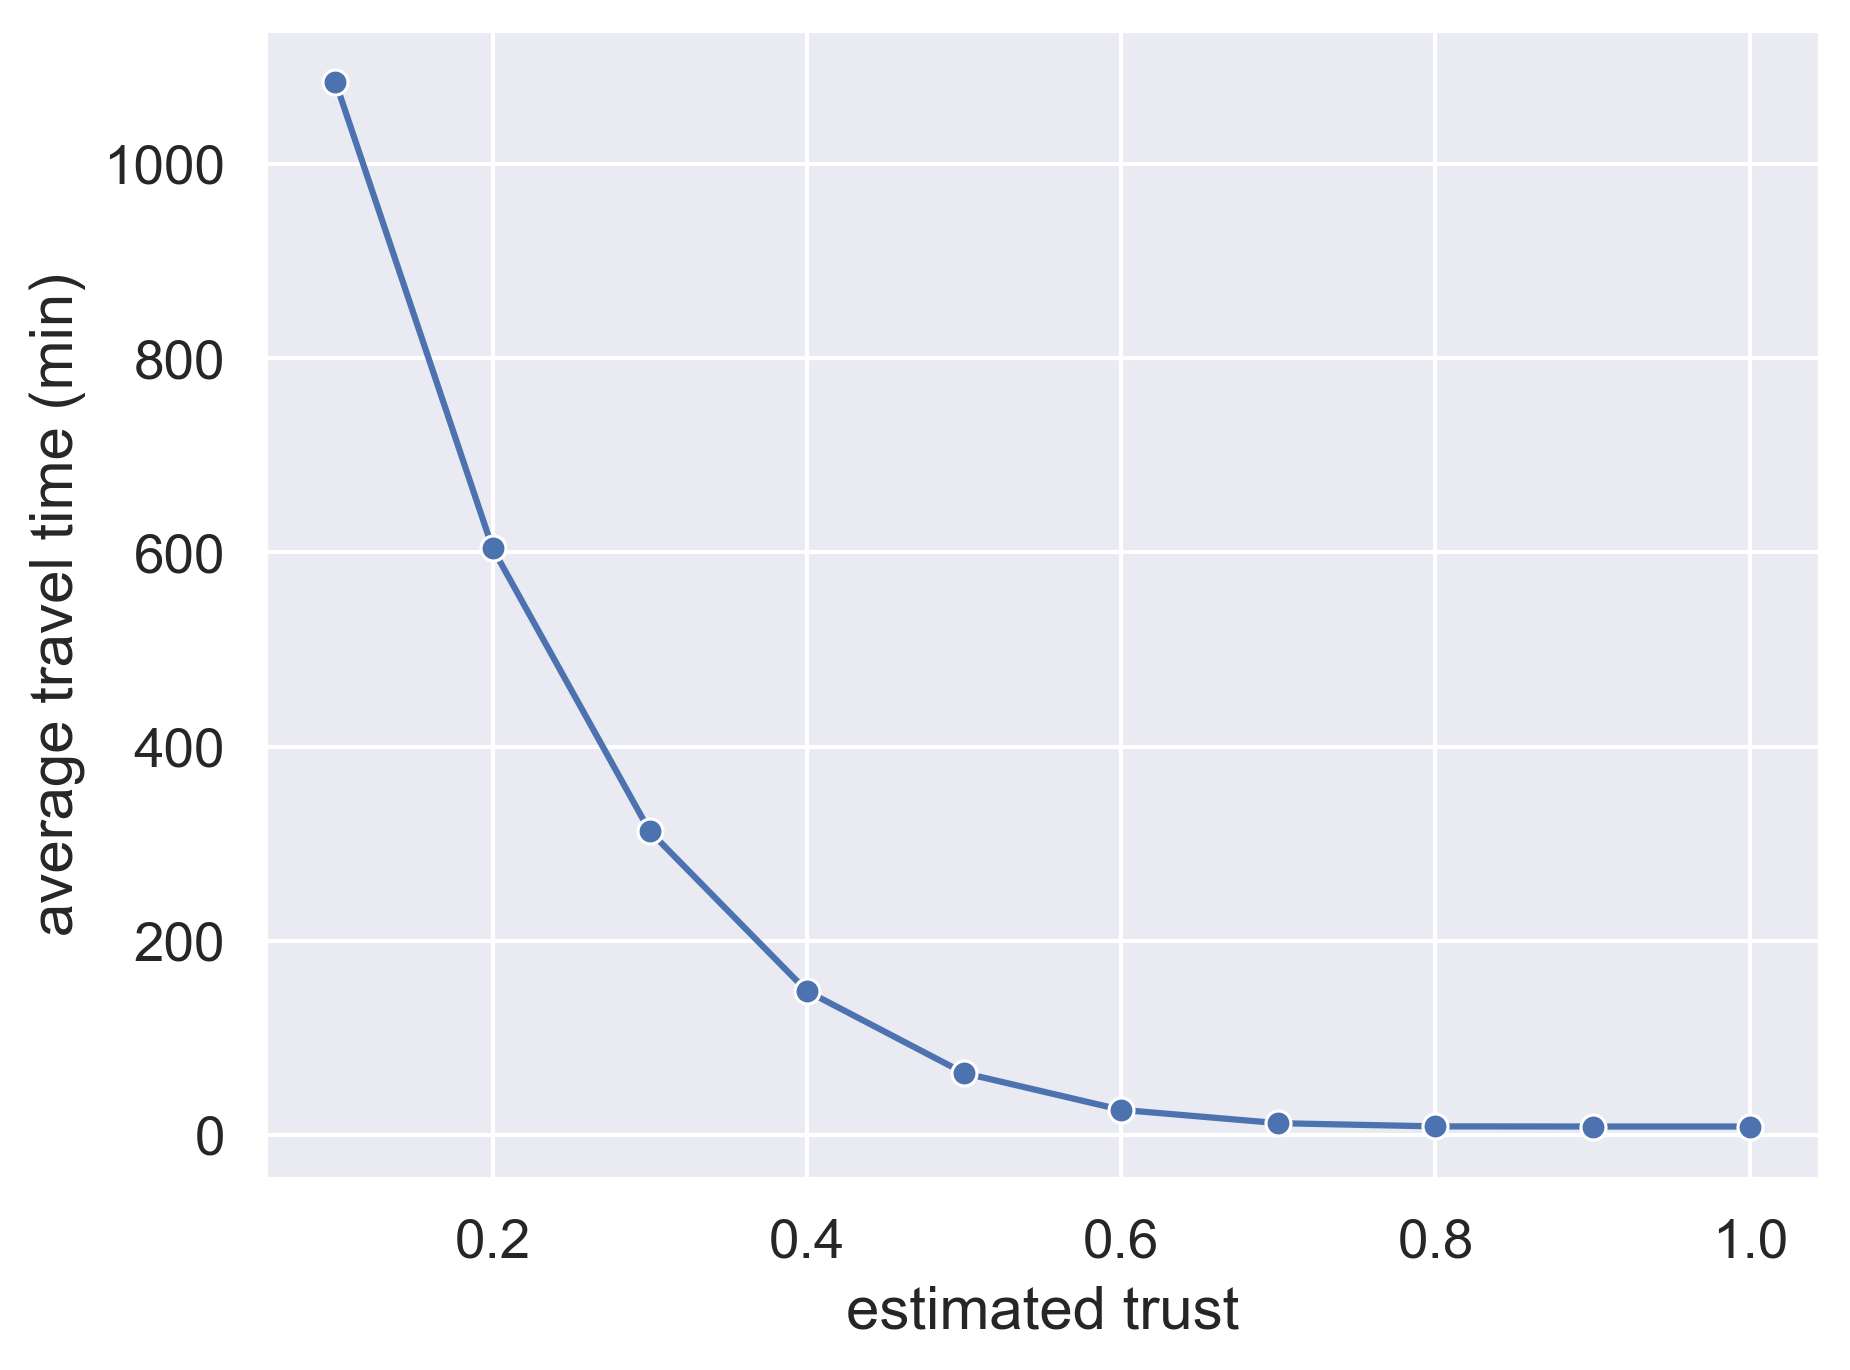

In [20]:
# plot the objective value by seaborn
avg_obj = np.array([obj / sum(demand.values()) for obj in obj_list])
print(np.round(avg_obj * 0.6, 2))
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})
# sns set font scale
sns.set(font_scale=1.2)
# add x label and y label by sns, with point at each data
ax = sns.lineplot(x=trust_list, y=avg_obj * 0.6, marker='o')
ax.set(xlabel='estimated trust', ylabel='average travel time (min)')
# save the figure
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('static_figure/sioux_falls_insample_obj.png')

In [10]:
# test true time
true_trust_list = np.arange(0.1, 1.1, 0.1)
all_true_time = np.zeros((len(trust_list), len(true_trust_list)))
for (i, single_trust) in enumerate(trust_list):
    for (j, single_true_trust) in enumerate(true_trust_list):
        true_trust = {}
        trust = {}
        for o in origin_node:
            true_trust[o] = single_true_trust
            trust[o] = single_trust
        all_true_time[len(trust_list) - i - 1, j] = static_model.true_time(
            x_val_list[i], bpr_params, free_flow_time, capacity, arc_set, trust, true_trust, num_nodes, origin_node,
            dest_node, demand, shortest_path)
all_true_time = all_true_time * 0.6 / sum(demand.values())

In [13]:
true_trust = {}
trust = {}
for o in origin_node:
    true_trust[o] = 0.2
    trust[o] = 1
print(static_model.true_time(
            x_val_list[9], bpr_params, free_flow_time, capacity, arc_set, trust, true_trust, num_nodes, origin_node,
            dest_node, demand, shortest_path) / sum(demand.values()) * 0.6)
print(obj_list[1] / sum(demand.values()) * 0.6)

Set parameter DualReductions to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 206 rows, 228 columns and 802 nonzeros
Model fingerprint: 0xcb1be41a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-05, 1e+01]
Presolve time: 0.01s
Presolved: 114 rows, 245 columns, 597 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.561307e+01   0.000000e+00      0s
     106    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 106 iterations and 0.02 seconds (0.00 work units)
Optimal objective  0.000000000e+00
{(0, 1): 0.0, (0, 2): 7.199901870149097e-05, (1, 0): 0.8847747512794468, (1, 5): 0.0, (2, 0): 2.8279984572655903, (2, 3): 8.000190047192343e-05, (2, 11): 0.0, (3, 2): 2.8281547935420557, 

In [14]:
all_true_time[8, 1] / sum(demand.values()) * 0.6

604.262485044403

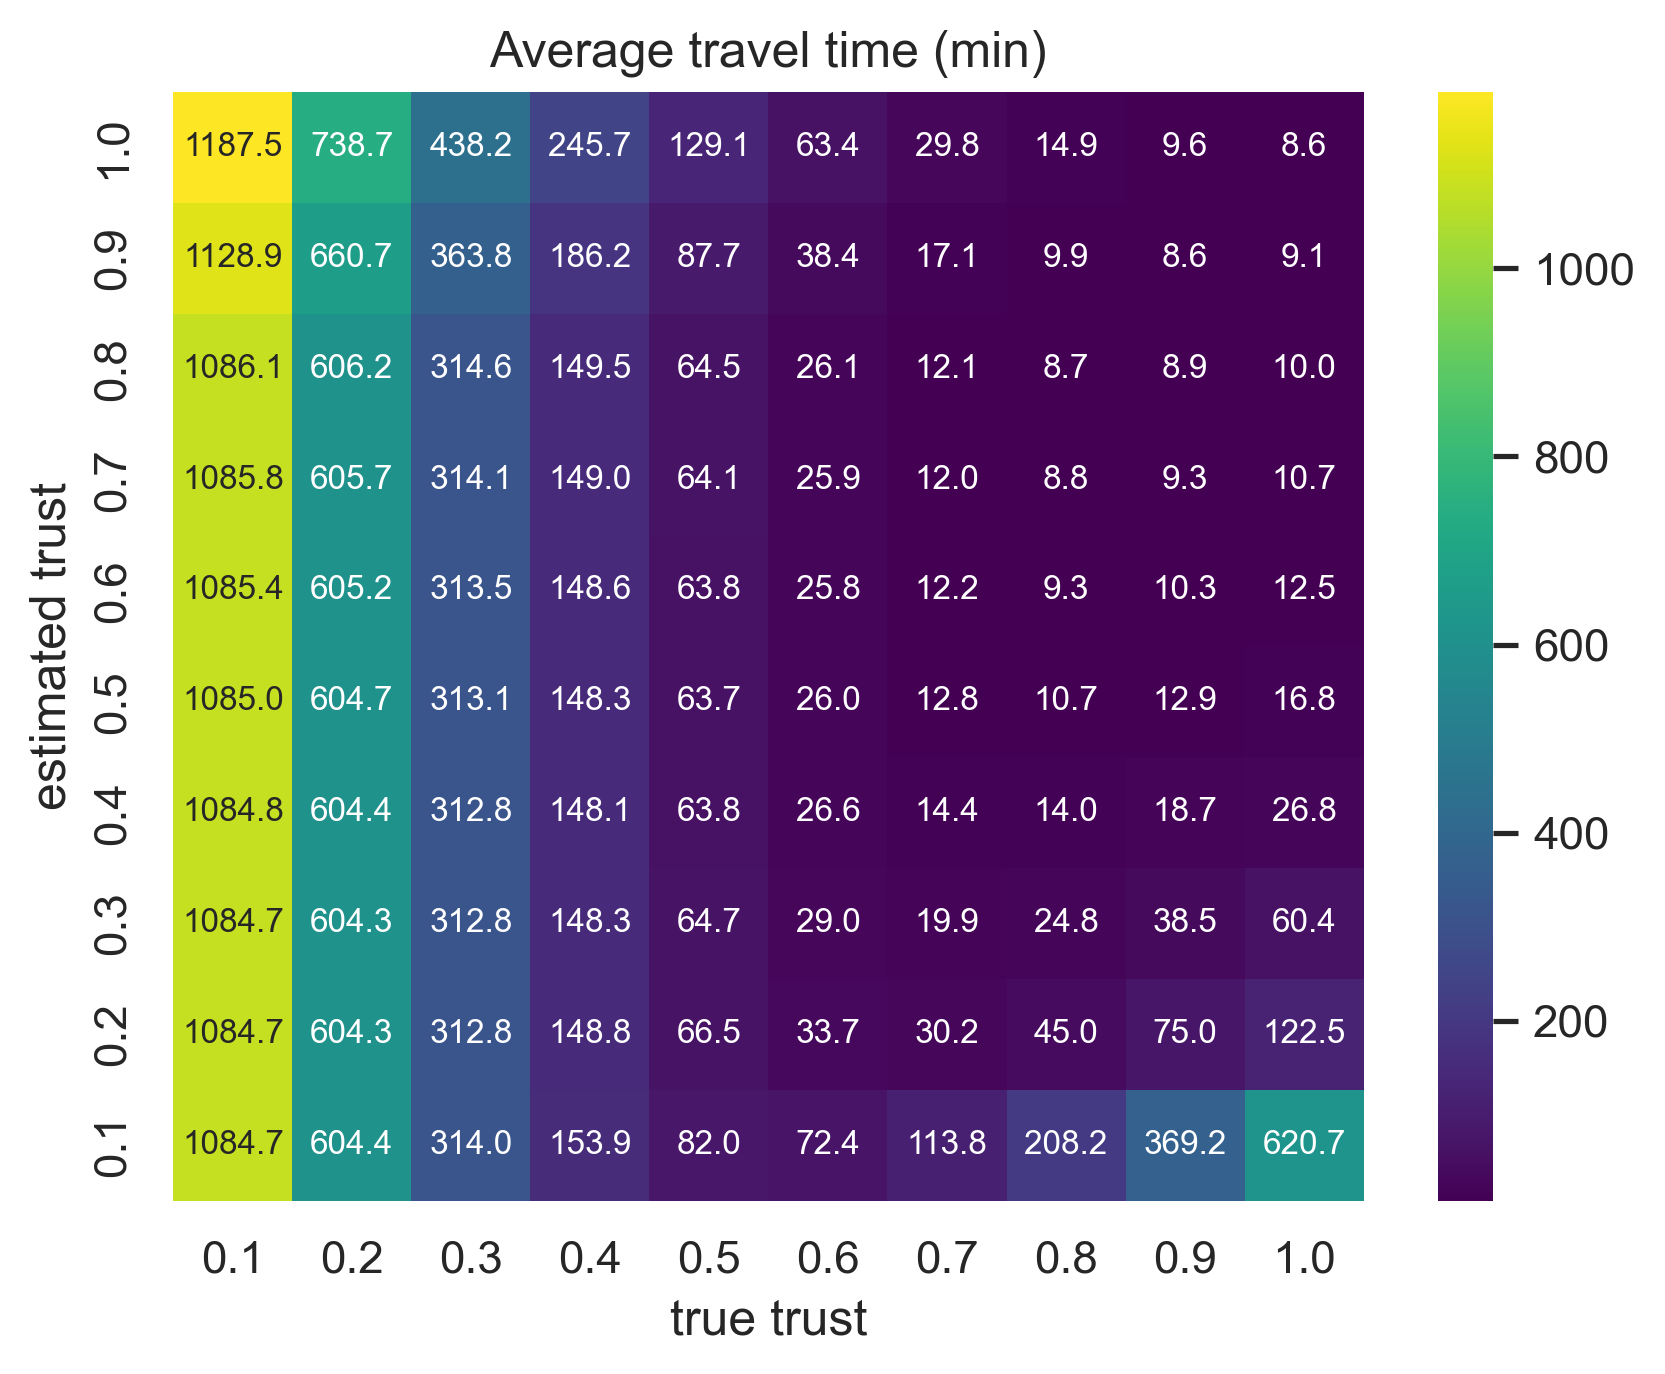

In [27]:
# plot the true time by seaborn
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})
# plot a heatmap, set font size of annotation
ax = sns.heatmap(all_true_time, xticklabels=true_trust_list.round(1), cmap='viridis',
                 yticklabels=trust_list.round(1)[::-1], annot=True, fmt='.1f', annot_kws={"size": 8})
ax.set(xlabel='true trust', ylabel='estimated trust')
ax.set_title('Average travel time (min)')
# save figure
fig = ax.get_figure()
fig.savefig('static_figure/sioux_falls_outsample_obj.png')

In [28]:
print(all_true_time)

[[1187.48584374  738.74779384  438.21277268  245.71545421  129.11510749
    63.40062676   29.79556142   14.86314608    9.61133056    8.59780991]
 [1128.86465015  660.70457223  363.78884357  186.1662557    87.66151406
    38.35962409   17.09027737    9.91223769    8.59772715    9.11681228]
 [1086.07526072  606.17486368  314.56529616  149.48089354   64.45477399
    26.13795946   12.11849684    8.74057894    8.92366558    9.98160467]
 [1085.76499652  605.7211303   314.08119876  149.03937565   64.1017726
    25.90518721   12.03585097    8.8481773     9.28350955   10.688869  ]
 [1085.3637985   605.16715002  313.53034901  148.58348525   63.79597978
    25.79430741   12.17971906    9.34596421   10.29701335   12.46478033]
 [1085.03491918  604.72679358  313.11303666  148.27601476   63.67431951
    25.96222664   12.80915478   10.71912431   12.85021614   16.83403054]
 [1084.76427291  604.37836035  312.81096986  148.12426576   63.8133363
    26.63384719   14.42969524   13.96066186   18.73006669   

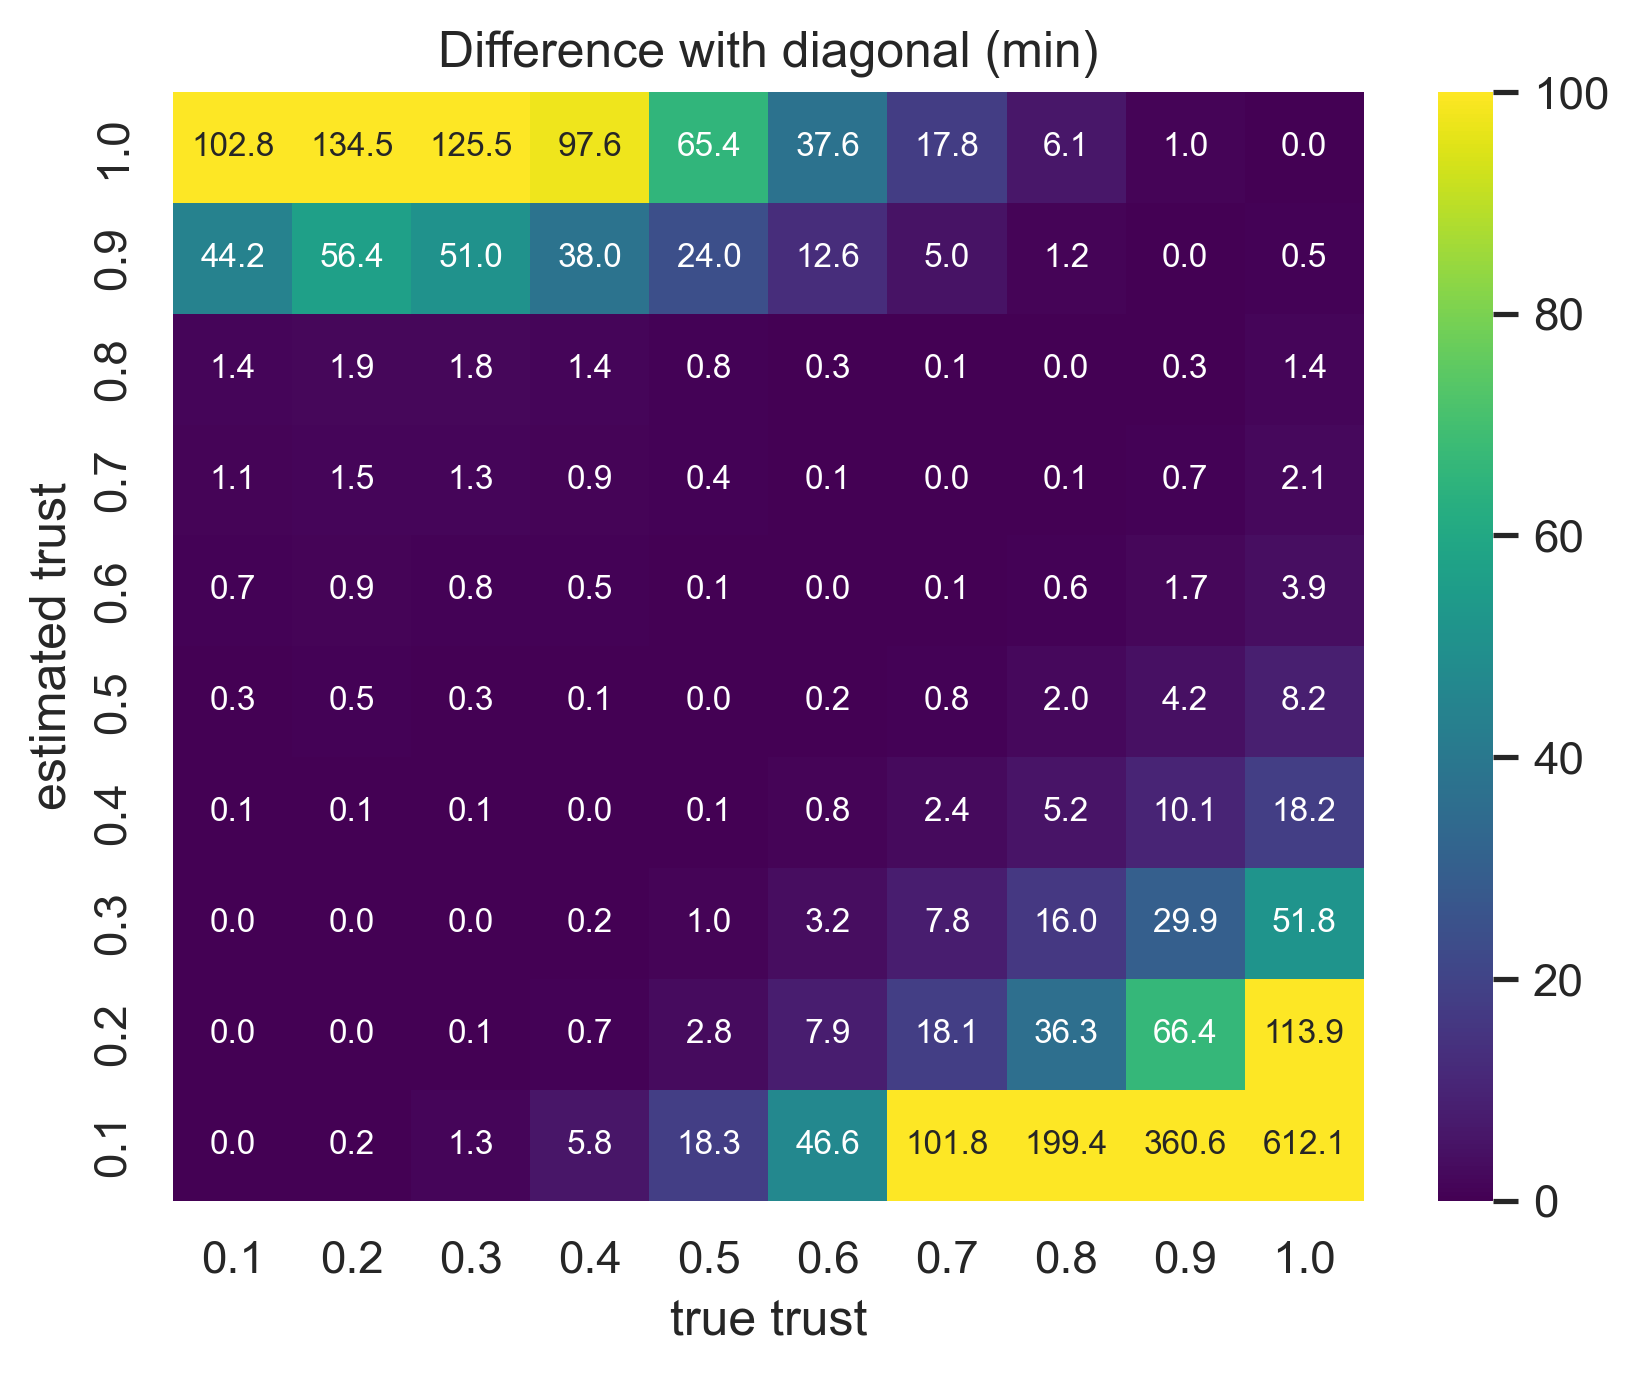

In [11]:
# compute the difference with diagonal
diff = np.zeros((len(trust_list), len(true_trust_list)))
for i in range(len(trust_list)):
    for j in range(len(true_trust_list)):
        diff[i, j] = all_true_time[i, j] - all_true_time[len(true_trust_list) - j - 1, j]
# round diff to 2 decimal
diff_r = np.round(diff, 2)
diff_r[diff_r < 0] = 0
# plot the difference by seaborn
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})
# plot a heatmap, set font size of annotation
ax = sns.heatmap(diff_r, xticklabels=true_trust_list.round(1), cmap='viridis',
                 yticklabels=trust_list.round(1)[::-1], annot=True, fmt='.1f', annot_kws={"size": 8}, vmax=100)
ax.set(xlabel='true trust', ylabel='estimated trust')
ax.set_title('Difference with diagonal (min)')
# save figure
fig = ax.get_figure()
fig.savefig('static_figure/sioux_falls_outsample_obj_diff.png')

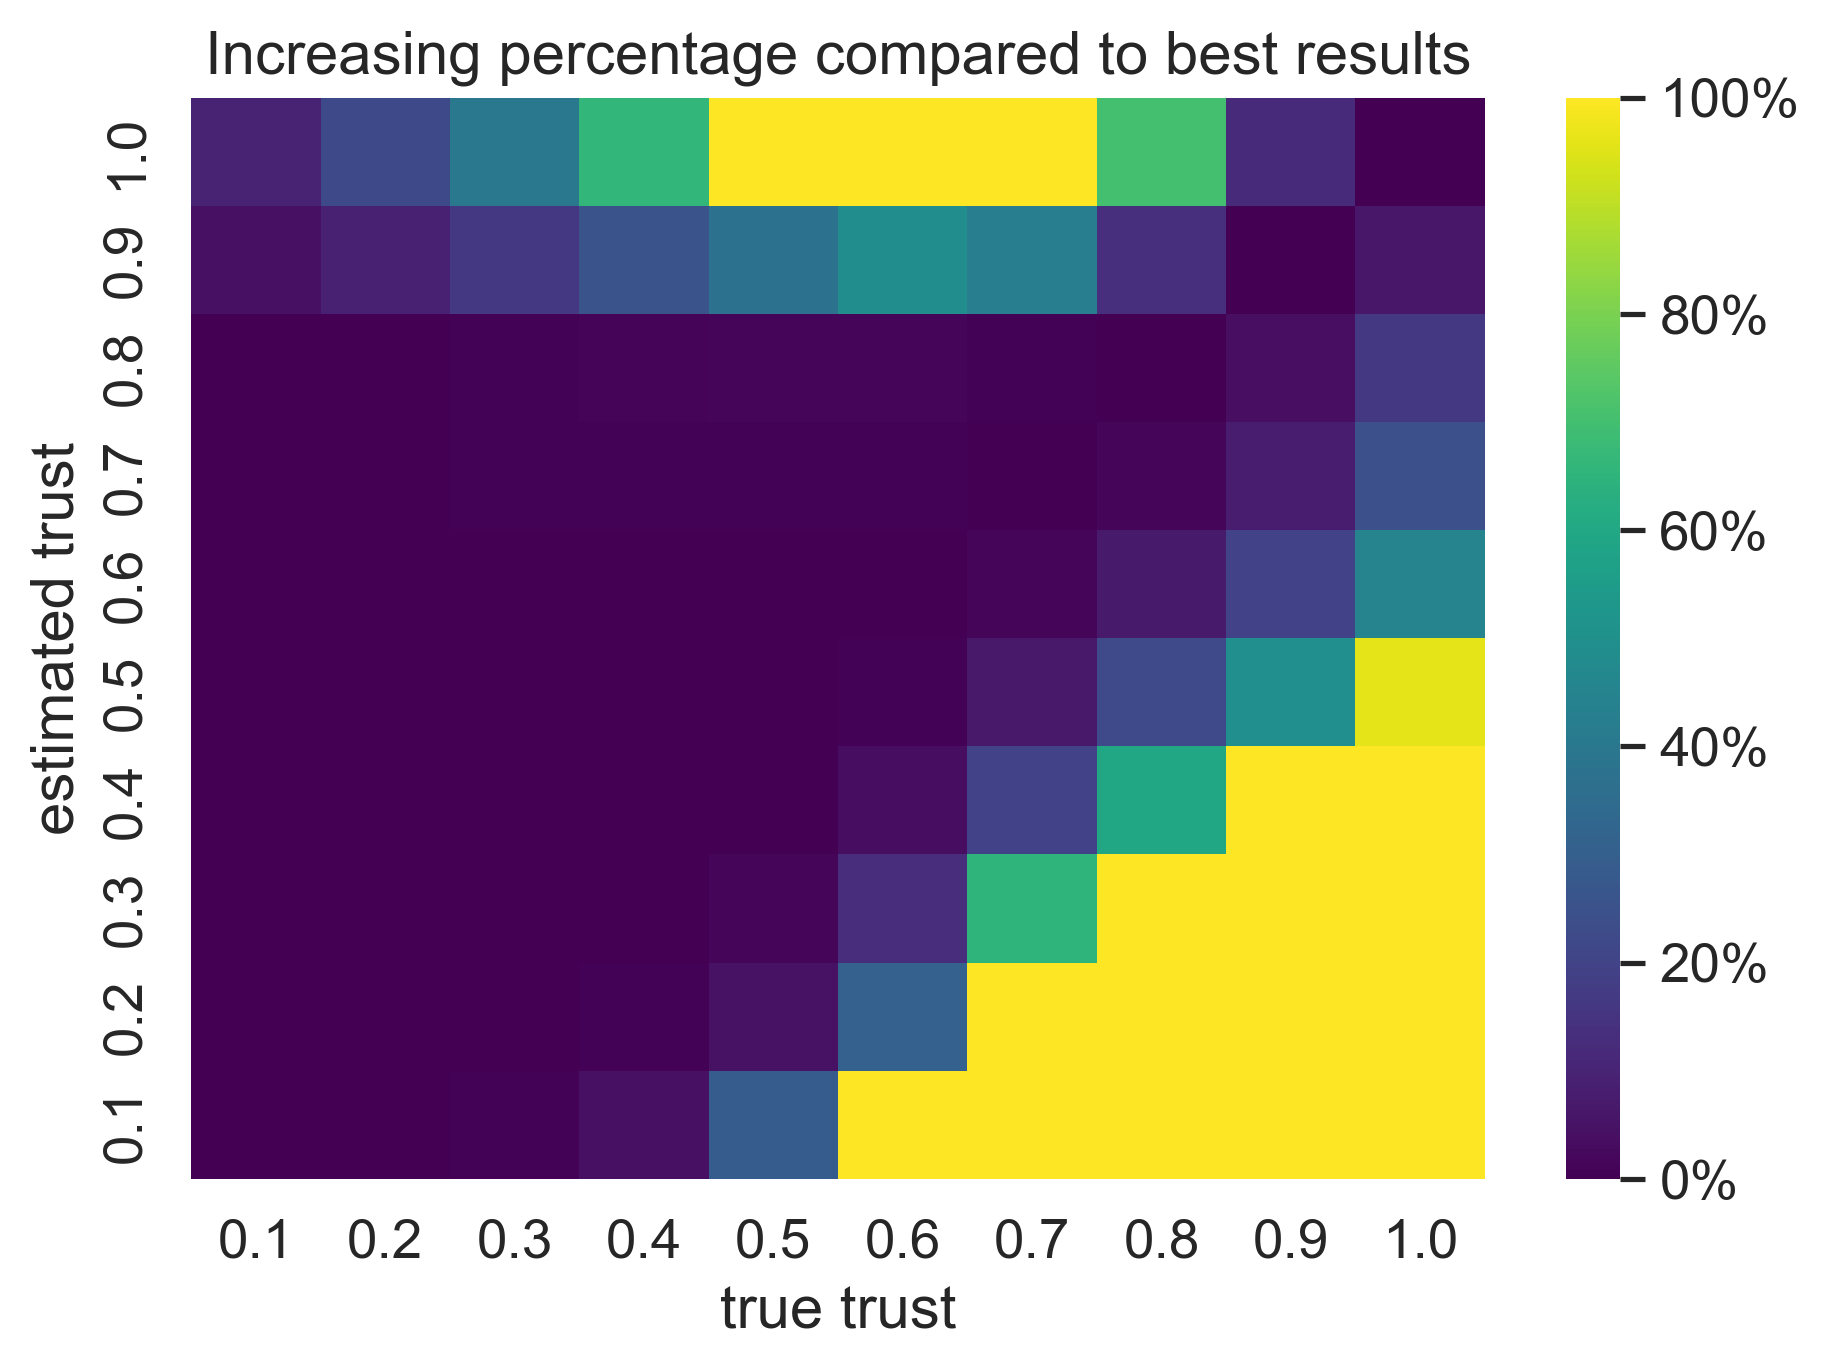

In [21]:
# compute the percentage difference with diagonal
per_diff = np.zeros((len(trust_list), len(true_trust_list)))
for i in range(len(trust_list)):
    for j in range(len(true_trust_list)):
        per_diff[i, j] = diff[i, j] / all_true_time[len(true_trust_list) - j - 1, j]
# print(per_diff)
# print(diff)
# plot the percentage difference by seaborn
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})
# set sns font scale
sns.set(font_scale=1.2)
# plot a heatmap, set font size of annotation
ax = sns.heatmap(per_diff, xticklabels=true_trust_list.round(1), cmap='viridis',
                 yticklabels=trust_list.round(1)[::-1], annot=False, fmt=".1%", annot_kws={"size": 6}, vmax=1)
# show colorbar as percentage
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.set(xlabel='true trust', ylabel='estimated trust')
ax.set_title('Increasing percentage compared to best results')
# save figure
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('static_figure/sioux_falls_outsample_obj_per_diff_no_annotation.png')

In [38]:
import gurobipy as gp
m = gp.Model()
x = m.addVars(6, 6, vtype=gp.GRB.BINARY)
cost_matrix = np.array([[1000000, 2000, 3250, 5250, 6750, 7750],
                        [1000000, 1000000, 2000, 3000, 4000, 4750],
                        [1000000, 1000000, 1000000, 2000, 250, 3000],
                        [1000000, 1000000, 1000000, 1000000, 2000, 2250],
                        [1000000, 1000000, 1000000, 1000000, 1000000, 2000],
                        [1000000, 1000000, 1000000, 1000000, 1000000, 1000000]])
m.setObjective(sum(cost_matrix[i, j] * x[i, j] for i in range(6) for j in range(6)), gp.GRB.MINIMIZE)
# add flow-balance constraints
for i in range(6):
    m.addConstr(sum(x[i, j] for j in range(6)) - sum(x[j, i] for j in range(6)) == 0)
# all summation larger than 1
m.addConstr(sum(x[i, j] for i in range(6) for j in range(6)) >= 1)
m.optimize()
print(x)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7 rows, 36 columns and 96 nonzeros
Model fingerprint: 0x37e27e04
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.505025e+07
Found heuristic solution: objective 1000000.0000
Presolve removed 0 rows and 5 columns
Presolve time: 0.00s
Presolved: 7 rows, 31 columns, 91 nonzeros
Variable types: 0 continuous, 31 integer (31 binary)

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1e+06 1.50502e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+06, best bound 1.000000000000e+06, gap 0.0000%

In [ ]:
# plot the true time by seaborn
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})
# plot a heatmap, set font size of annotation
# set format as percentage
ax = sns.heatmap(all_true_time[:6, 4:] * 0.6 / sum(demand.values()), xticklabels=true_trust_list[4:].round(1), cmap='viridis',
                 yticklabels=trust_list[4:].round(1)[::-1], annot=True, fmt=".1f", annot_kws={"size": 10})
ax.set(xlabel='estimated trust', ylabel='true trust')
ax.set_title('Average travel time (min)')
# save figure
fig = ax.get_figure()
fig.savefig('static_figure/sioux_falls_outsample_obj_zoomin.png')

In [ ]:
# define a network graph and visualize the network
def draw_flow(index):
    G = nx.DiGraph(directed=True)
    # G.add_nodes_from(range(num_nodes))
    # add edges with given flow
    used_nodes = []
    for arc in arc_set:
        # add edge as directed link with flow as label
        if np.round(x_val_list[index][arc], 2) > 1e-4:
            if arc[0] not in used_nodes:
                G.add_node(arc[0])
                used_nodes.append(arc[0])
            if arc[1] not in used_nodes:
                G.add_node(arc[1])
                used_nodes.append(arc[1])
            G.add_edge(arc[0], arc[1], flow=np.round(x_val_list[index][arc], 2))
    # visualize the graph
    # pos = nx.spring_layout(G, seed=2)
    df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
    for row, data in nx.shortest_path_length(G):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    pos = nx.kamada_kawai_layout(G, dist=df.to_dict())
    # draw node with id as label
    # nx.draw_networkx_nodes(G, pos, node_size=25)
    # nx.draw_networkx_labels(G, pos, font_size=8)
    # nx.draw_networkx_edges(G, pos, width=0.5, arrows=True, arrowstyle='->', arrowsize=2)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black',
            connectionstyle='arc3, rad = 0.1', arrowsize=10)
    # add flow as label to edges
    labels = nx.get_edge_attributes(G, 'flow')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=5)

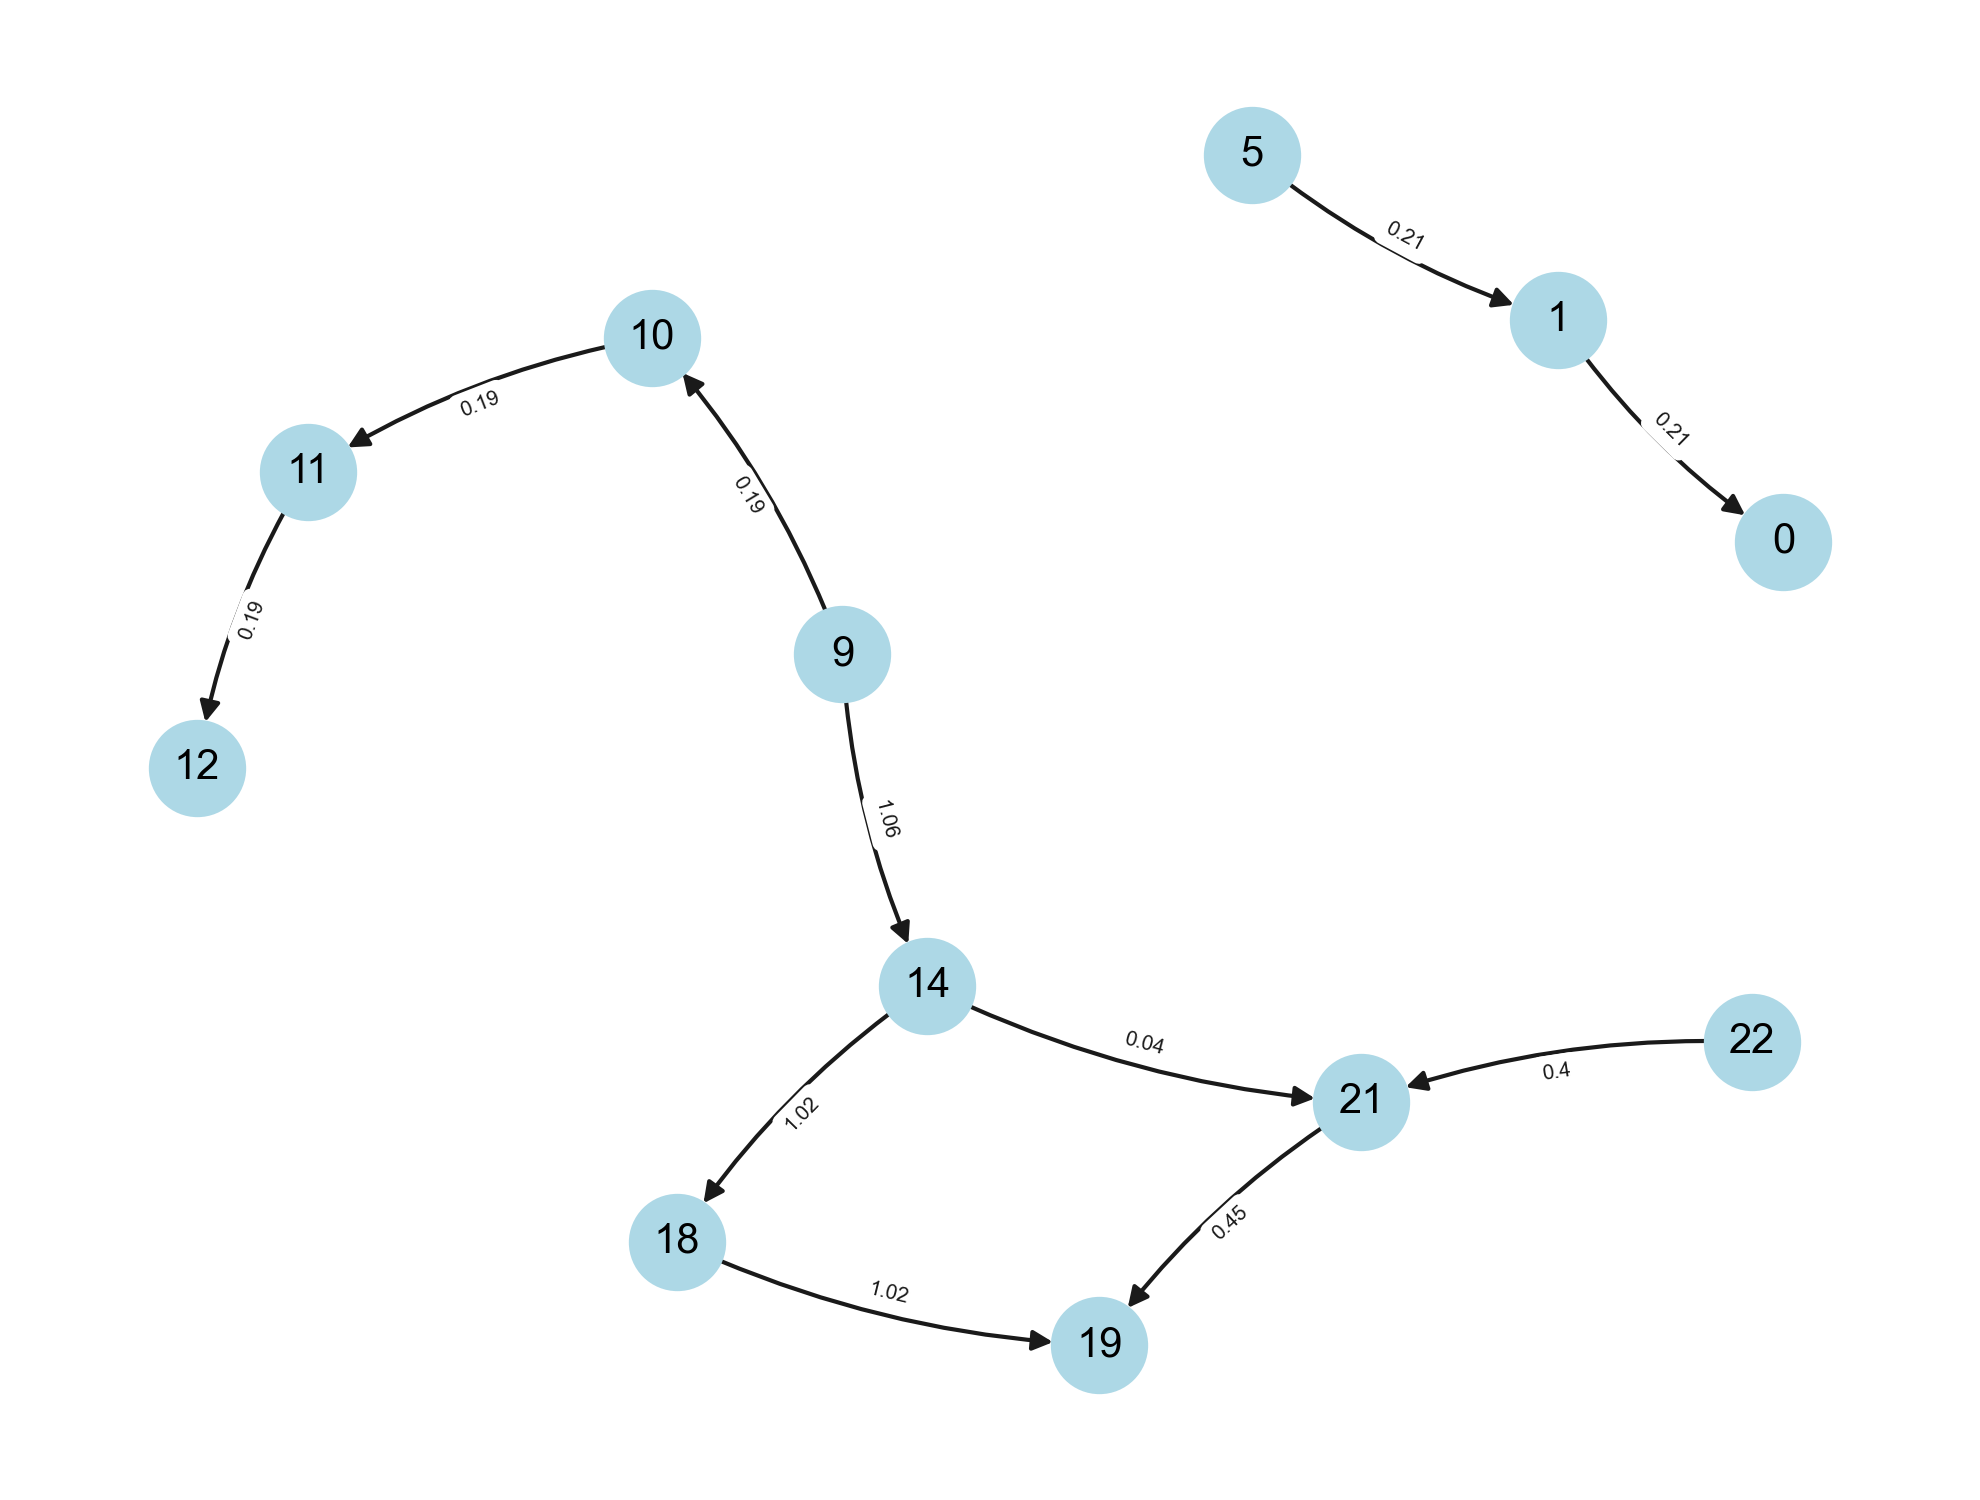

In [88]:
draw_flow(0)

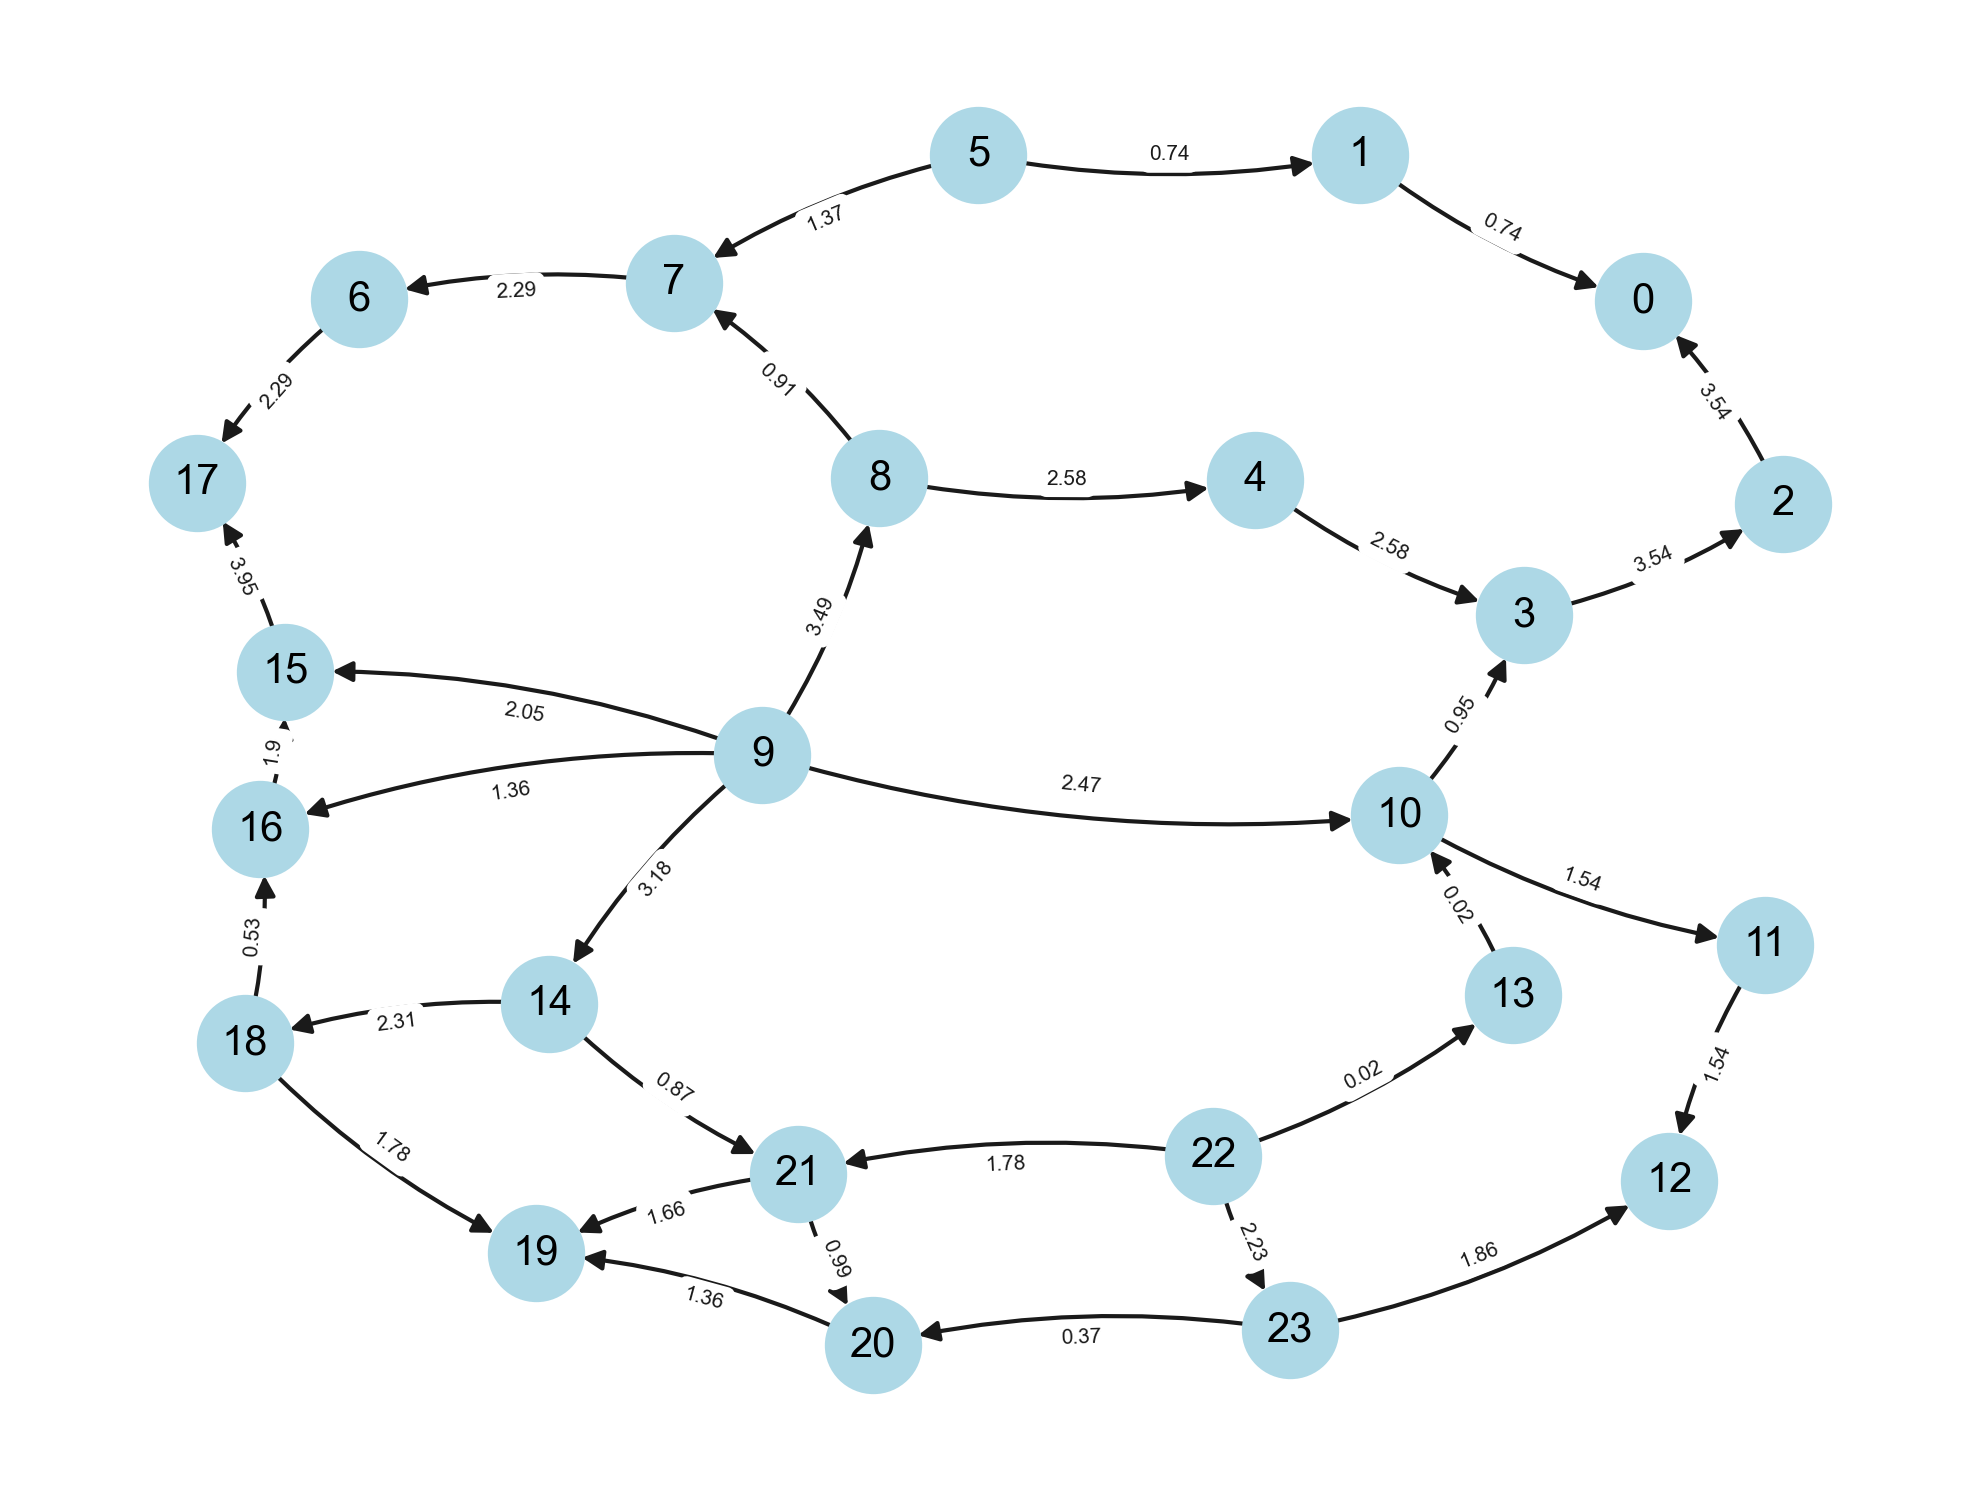

In [89]:
draw_flow(9)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node('A')
G.add_node('B')

# Add directed edges
G.add_edge('A', 'B', label='Edge from A to B')
G.add_edge('B', 'A', label='Edge from B to A')  # Reverse direction

# Manually set positions for nodes
pos = {'A': (0, 0), 'B': (1, 0)}  # Adjust the positions as needed

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', arrowsize=10,
        connectionstyle='arc3, rad = 0.1')
edge_labels = nx.get_edge_attributes(G, 'label')
edge_label_positions = {edge: (0.5, 0) for edge in edge_labels}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.3, verticalalignment='baseline',
                             bbox=dict(facecolor='none', edgecolor='none', alpha=0))

# Show the plot
plt.show()

In [67]:
h = gv.Digraph(format='png')
for u, d in G.nodes(data=True):
    h.node(str(u), label=d['label'])
for u, v, d in G.edges(data=True):
    print(d)
    h.edge(str(u), str(v), label=d['label'])

KeyError: 'label'